<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Sequence length](#2-sequence-length)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [48]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df, \
                         choose_best_patchtst_model, \
                         calculate_improvement
                         
from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


# 1. Input length

In [49]:
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

all_df_store = pd.concat([patchtst_21_df, patchtst_df, patchtst_64_df], axis=1)

# Change country codes to country names
level_names = all_df_store.index.names
all_df_store.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df_store.index],
    names=level_names
)
# Scale
scale = 10**2
all_df_scale_store = all_df_store * scale

# With best PatchTST configurations
result_df_unscaled = choose_best_patchtst_model(all_df_store)
result_df = result_df_unscaled * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df


In [50]:
best_vs_base = pd.concat([result_df, all_df_scale_store.loc[:, all_df_store.columns.get_level_values('Model') == 'PatchTST/42']], axis=1)
best_vs_base = calculate_improvement(best_vs_base, 
                                      base_mae_model='PatchTST', 
                                      model_to_compare_mae='PatchTST/42',
                                      grouped_by_models=False)
print(f"Average improvement of MAE: {(best_vs_base.loc[best_vs_base['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(best_vs_base.loc[best_vs_base['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 1.44 %.
Average improvement of RMSE: 1.07 %.


In [51]:
best_vs_base['mae_improvement'] = best_vs_base['mae_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base['rmse_improvement'] = best_vs_base['rmse_improvement'].apply(lambda x: str(x) + '%' if x != 0 else '--')
best_vs_base.round(2)

Model                   PatchTST        PatchTST/42        rmse_improvement  \
Metrics                     RMSE    MAE        RMSE    MAE                    
Country        Pred_len                                                       
Germany        24          14.48   8.77       14.48   8.77               --   
               96          18.94  12.50       19.41  12.83            2.44%   
               168         19.68  13.27       19.81  13.39            0.65%   
Spain          24           9.88   5.92        9.88   5.92               --   
               96          13.61   8.61       13.61   8.61               --   
               168         14.39   9.16       14.39   9.16               --   
France         24           9.98   5.44       10.00   5.48            0.13%   
               96          13.85   7.89       13.90   8.08            0.38%   
               168         14.50   8.56       14.60   8.68            0.68%   
United Kingdom 24          15.70   9.90       15.82   9.96            0.77%   
               96          20.27  13.90       20.45  13.95             0.9%   
               168         20.85  14.49       21.15  14.68            1.42%   
Italy          24          10.00   5.66       10.04   5.67            0.36%   
               96          13.52   7.89       13.71   8.07            1.39%   
               168         14.11   8.45       14.48   8.72            2.61%   

Model                   mae_improvement  
Metrics                                  
Country        Pred_len                  
Germany        24                    --  
               96                 2.55%  
               168                0.93%  
Spain          24                    --  
               96                    --  
               168                   --  
France         24                 0.81%  
               96                 2.39%  
               168                1.37%  
United Kingdom 24                 0.61%  
               96                 0.41%  
               168                1.31%  
Italy          24                 0.11%  
               96                 2.23%  
               168                3.13%

In [52]:
print(best_vs_base[['mae_improvement', 'rmse_improvement']].reset_index(drop=True))

Model   mae_improvement rmse_improvement
Metrics                                 
0                    --               --
1                 2.55%            2.44%
2                 0.93%            0.65%
3                    --               --
4                    --               --
5                    --               --
6                 0.81%            0.13%
7                 2.39%            0.38%
8                 1.37%            0.68%
9                 0.61%            0.77%
10                0.41%             0.9%
11                1.31%            1.42%
12                0.11%            0.36%
13                2.23%            1.39%
14                3.13%            2.61%


In [53]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_input_length_10_power_2.html'), index=True)

# 2. Comparison of models

In [54]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )

# Concat all dfs with default PatchTST
all_df = pd.concat([patchtst_df, informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [55]:
# Concat all dfs with best PatchTST - FINAL TABLE
all_df_with_result = pd.concat(
    [result_df, all_df_scale.loc[:, all_df_scale.columns.get_level_values('Model') != 'PatchTST/42']],
    axis=1
)

unscaled_for_plots = all_df_with_result / scale

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimum values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2)
styled_df

In [56]:
informer_improvement = all_df_with_result.copy()
informer_improvement = calculate_improvement(informer_improvement, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer',
                      grouped_by_models=False).round(2)
informer_improvement

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.48   8.77    16.03  10.28    11.15   9.32   
               96          18.94  12.50    20.66  14.33    20.28  16.49   
               168         19.68  13.27    22.43  15.45    22.79  18.51   
Spain          24           9.88   5.92    16.32   9.77     9.68   7.89   
               96          13.61   8.61    24.65  15.40    14.17  11.22   
               168         14.39   9.16    23.43  14.95    17.61  13.59   
France         24           9.98   5.44    11.39   6.47     7.60   6.06   
               96          13.85   7.89    14.91   9.07    12.54   9.81   
               168         14.50   8.56    15.47   9.71    14.89  11.50   
United Kingdom 24          15.70   9.90    19.03  12.42    14.41  12.01   
               96          20.27  13.90    23.61  16.30    21.53  17.69   
               168         20.85  14.49    23.86  16.61    22.67  18.28   
Italy          24          10.00   5.66    11.02   6.46     8.64   6.98   
               96          13.52   7.89    14.51   8.98    13.12  10.33   
               168         14.11   8.45    14.82   9.37    16.57  12.76   

Model                   Persistence        rmse_improvement mae_improvement  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             9.66           14.66  
               96             26.14  19.69             8.32           12.76  
               168            23.39  17.01            12.25           14.14  
Spain          24             14.06   9.43            39.45           39.38  
               96             19.67  13.92            44.77           44.09  
               168            17.74  12.38            38.58           38.72  
France         24             12.24   8.00            12.31           15.90  
               96             17.82  12.50             7.15           13.03  
               168            16.29  10.81             6.23           11.89  
United Kingdom 24             19.89  14.45            17.50           20.32  
               96             25.54  19.42            14.13           14.73  
               168            24.69  18.56            12.62           12.74  
Italy          24             14.40   9.66             9.28           12.38  
               96             19.71  14.10             6.85           12.07  
               168            15.69  10.92             4.81            9.82

In [57]:
informer_improvement['mae_improvement'].groupby('Country').mean()

Country
France            13.606667
Germany           13.853333
Italy             11.423333
Spain             40.730000
United Kingdom    15.930000
Name: mae_improvement, dtype: float64

In [58]:
informer_improvement['rmse_improvement'].groupby('Country').mean()

Country
France             8.563333
Germany           10.076667
Italy              6.980000
Spain             40.933333
United Kingdom    14.750000
Name: rmse_improvement, dtype: float64

In [59]:
print(f"Average improvement of MAE: {(informer_improvement.loc[informer_improvement['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(informer_improvement.loc[informer_improvement['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average improvement of MAE: 19.11 %.
Average improvement of RMSE: 16.26 %.


In [60]:
second_best_improvement = all_df_with_result.copy()
second_best_improvement = calculate_improvement(second_best_improvement, 
                      base_mae_model='PatchTST', 
                      grouped_by_models=False).round(2)
second_best_improvement
                                                    

Model                   PatchTST        Informer        (S)ARIMA         \
Metrics                     RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country        Pred_len                                                   
Germany        24          14.48   8.77    16.03  10.28    11.15   9.32   
               96          18.94  12.50    20.66  14.33    20.28  16.49   
               168         19.68  13.27    22.43  15.45    22.79  18.51   
Spain          24           9.88   5.92    16.32   9.77     9.68   7.89   
               96          13.61   8.61    24.65  15.40    14.17  11.22   
               168         14.39   9.16    23.43  14.95    17.61  13.59   
France         24           9.98   5.44    11.39   6.47     7.60   6.06   
               96          13.85   7.89    14.91   9.07    12.54   9.81   
               168         14.50   8.56    15.47   9.71    14.89  11.50   
United Kingdom 24          15.70   9.90    19.03  12.42    14.41  12.01   
               96          20.27  13.90    23.61  16.30    21.53  17.69   
               168         20.85  14.49    23.86  16.61    22.67  18.28   
Italy          24          10.00   5.66    11.02   6.46     8.64   6.98   
               96          13.52   7.89    14.51   8.98    13.12  10.33   
               168         14.11   8.45    14.82   9.37    16.57  12.76   

Model                   Persistence        improvement_rmse improvement_mae  
Metrics                        RMSE    MAE                                   
Country        Pred_len                                                      
Germany        24             19.61  13.87             0.00            5.89  
               96             26.14  19.69             6.62           12.76  
               168            23.39  17.01            12.25           14.14  
Spain          24             14.06   9.43             0.00           24.90  
               96             19.67  13.92             3.92           23.24  
               168            17.74  12.38            18.26           26.02  
France         24             12.24   8.00             0.00           10.19  
               96             17.82  12.50             0.00           13.03  
               168            16.29  10.81             2.60           11.89  
United Kingdom 24             19.89  14.45             0.00           17.64  
               96             25.54  19.42             5.84           14.73  
               168            24.69  18.56             8.03           12.74  
Italy          24             14.40   9.66             0.00           12.38  
               96             19.71  14.10             0.00           12.07  
               168            15.69  10.92             4.81            9.82

In [61]:
print(f"Average improvement of MAE: {(second_best_improvement.loc[second_best_improvement['improvement_mae']!=0]['improvement_mae'].mean()).round(2)} %.")
print(f"Average improvement of RMSE: {(second_best_improvement.loc[second_best_improvement['improvement_rmse']!=0]['improvement_rmse'].mean()).round(2)} %.")

Average improvement of MAE: 14.76 %.
Average improvement of RMSE: 7.79 %.


In [62]:
second_best_improvement['improvement_mae'].groupby('Country').mean()

Country
France            11.703333
Germany           10.930000
Italy             11.423333
Spain             24.720000
United Kingdom    15.036667
Name: improvement_mae, dtype: float64

In [63]:
second_best_improvement['improvement_rmse'].groupby('Country').mean()

Country
France            0.866667
Germany           6.290000
Italy             1.603333
Spain             7.393333
United Kingdom    4.623333
Name: improvement_rmse, dtype: float64

In [64]:
second_best_improvement['improvement_mae'].groupby('Pred_len').mean()

Pred_len
24     14.200
96     15.166
168    14.922
Name: improvement_mae, dtype: float64

In [65]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'model_comparison_10_power_2.html'), index=True)

Create plots.

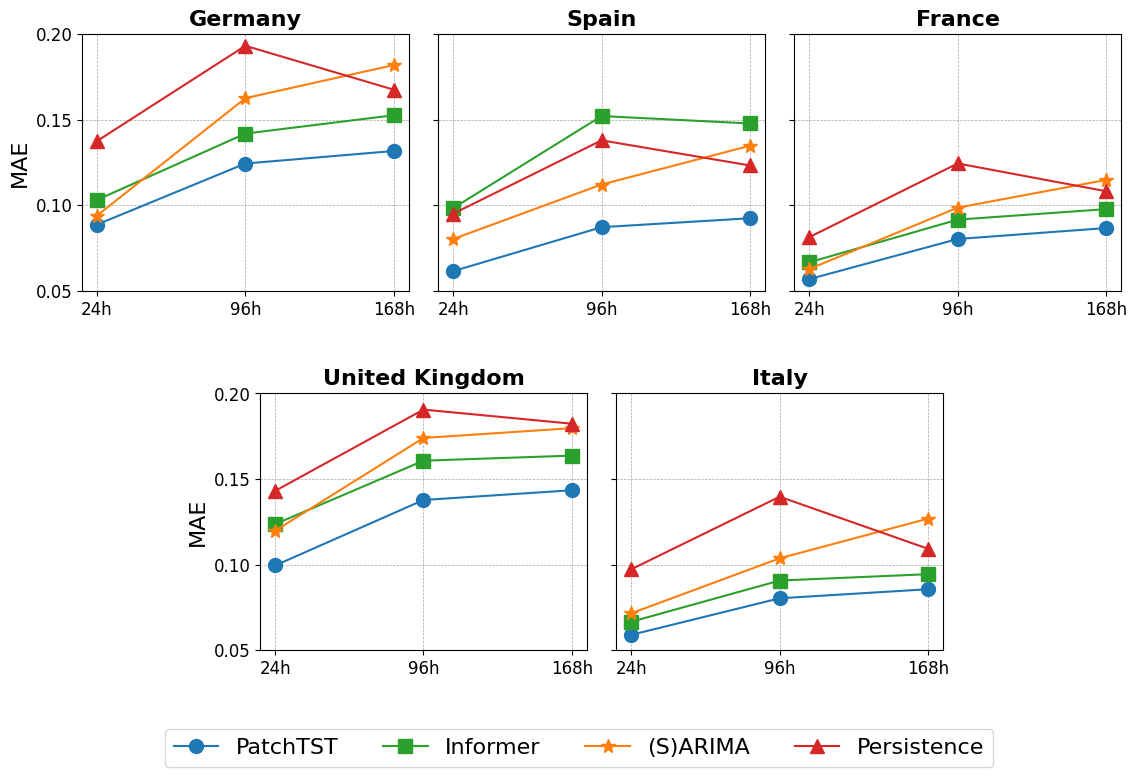

In [66]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

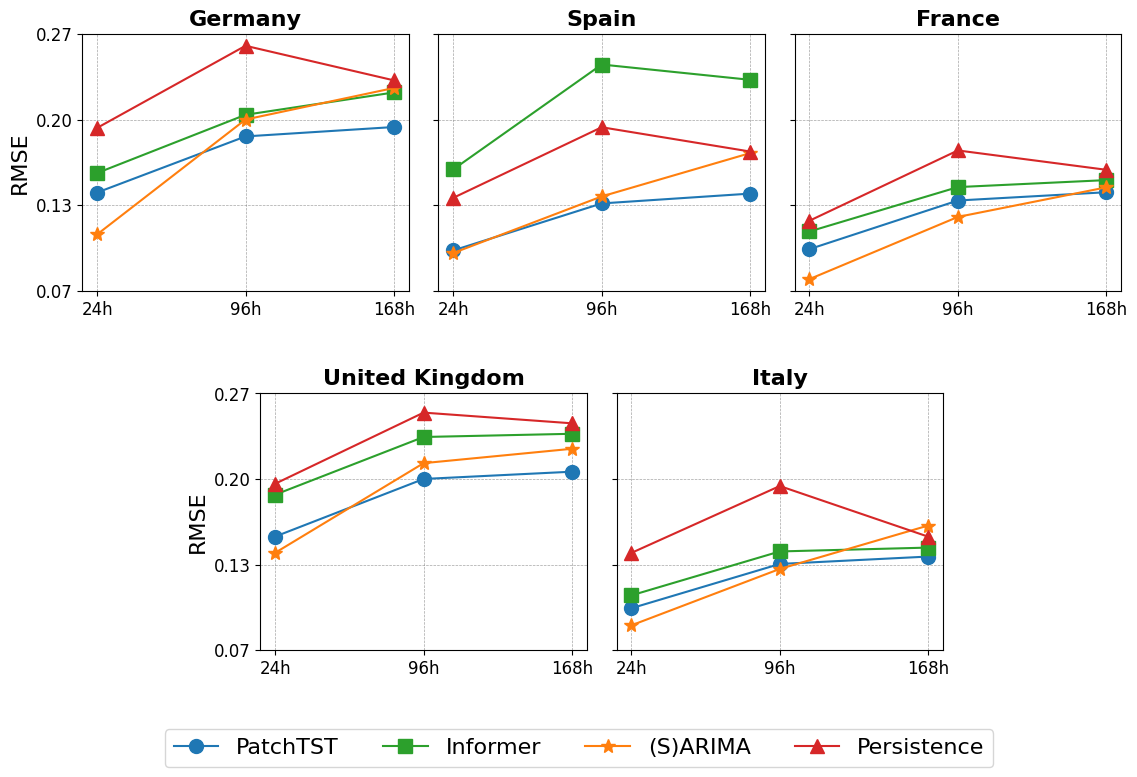

In [67]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

# 3. Self-supervised

In [68]:
# Read data
self_supervised = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    )

# Change country codes to country names
self_supervised.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in self_supervised.index],
    names=level_names
)

all_df = pd.concat([self_supervised, result_df_unscaled], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [69]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

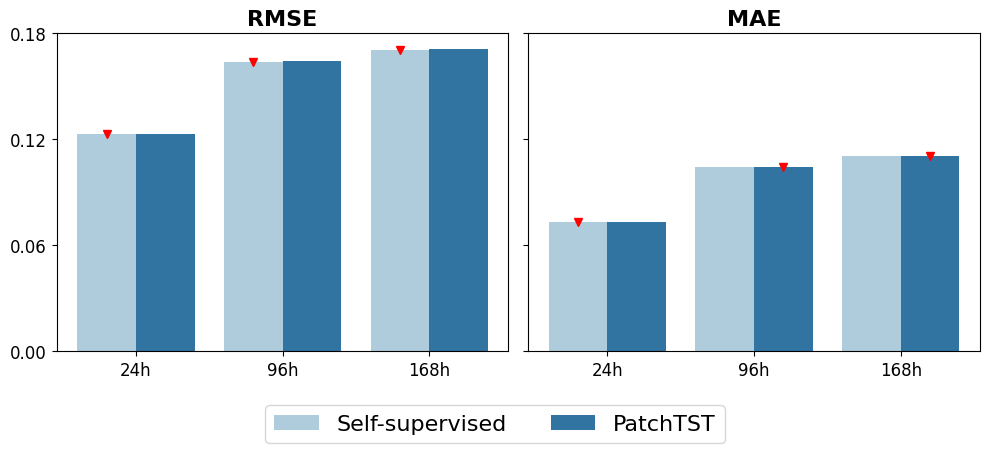

In [70]:
# all together
# Not visible
# Averaged by country
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

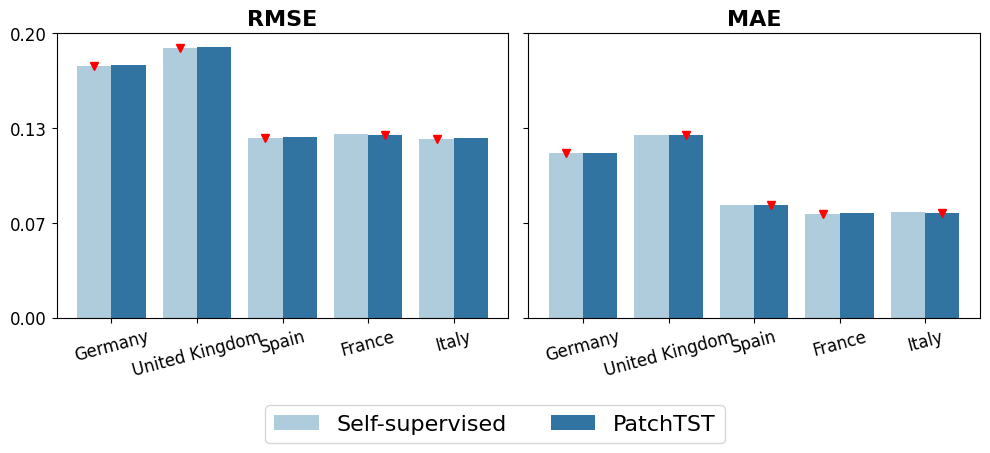

In [71]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

# 4. Ablation study

In [72]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

all_df = pd.concat([result_df_unscaled, all_df], axis=1)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

In [73]:
revin = all_df_scale.copy()
revin = calculate_improvement(revin, 
                      base_mae_model='-RevIN', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
revin

Model                   PatchTST        -RevIN            CM            -P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.48   8.77  14.73   9.14  16.26  10.55  14.72   
               96          18.94  12.50  19.45  12.99  21.17  14.47  19.10   
               168         19.68  13.27  21.43  14.11  21.04  14.41  19.59   
Spain          24           9.88   5.92  11.30   7.28  10.71   6.77  10.34   
               96          13.61   8.61  18.01  11.38  14.69   9.70  13.90   
               168         14.39   9.16  17.48  11.65  15.38  10.34  14.72   
France         24           9.98   5.44  10.55   6.10  10.39   5.82  10.37   
               96          13.85   7.89  14.29   8.36  13.99   8.31  14.18   
               168         14.50   8.56  15.20   8.99  14.29   8.73  14.78   
United Kingdom 24          15.70   9.90  16.08  10.38  16.99  11.54  16.21   
               96          20.27  13.90  20.79  14.33  20.85  14.52  20.61   
               168         20.85  14.49  21.86  15.05  21.35  14.99  21.02   
Italy          24          10.00   5.66  10.42   6.26  10.20   5.84  10.21   
               96          13.52   7.89  13.65   8.37  13.91   8.34  13.67   
               168         14.11   8.45  14.11   8.77  14.32   8.80  14.10   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.09            -1.73           -4.21  
               96        12.67            -2.71           -3.90  
               168       13.25            -8.87           -6.39  
Spain          24         6.32           -14.33          -22.94  
               96         8.94           -32.27          -32.20  
               168        9.60           -21.47          -27.20  
France         24         5.74            -5.72          -12.11  
               96         8.22            -3.23           -5.92  
               168        8.77            -4.79           -5.06  
United Kingdom 24        10.36            -2.44           -4.92  
               96        13.91            -2.56           -3.15  
               168       14.45            -4.84           -3.83  
Italy          24         5.87            -4.20          -10.60  
               96         8.15            -0.99           -6.02  
               168        8.57            -0.00           -3.86

In [74]:
revin['mae_improvement'].groupby('Country').mean()

Country
France            -7.696667
Germany           -4.833333
Italy             -6.826667
Spain            -27.446667
United Kingdom    -3.966667
Name: mae_improvement, dtype: float64

In [75]:
revin['rmse_improvement'].groupby('Country').mean()

Country
France            -4.580000
Germany           -4.436667
Italy             -1.730000
Spain            -22.690000
United Kingdom    -3.280000
Name: rmse_improvement, dtype: float64

In [76]:
revin['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -10.956
96    -10.238
168    -9.268
Name: mae_improvement, dtype: float64

In [77]:
print(f"Average reduction of MAE: {(revin.loc[revin['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(revin.loc[revin['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -10.15 %.
Average reduction of RMSE: -7.87 %.


In [78]:
channel_mixing = all_df_scale.copy()
channel_mixing = calculate_improvement(channel_mixing, 
                      base_mae_model='CM', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
channel_mixing

Model                   PatchTST        -RevIN            CM            -P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.48   8.77  14.73   9.14  16.26  10.55  14.72   
               96          18.94  12.50  19.45  12.99  21.17  14.47  19.10   
               168         19.68  13.27  21.43  14.11  21.04  14.41  19.59   
Spain          24           9.88   5.92  11.30   7.28  10.71   6.77  10.34   
               96          13.61   8.61  18.01  11.38  14.69   9.70  13.90   
               168         14.39   9.16  17.48  11.65  15.38  10.34  14.72   
France         24           9.98   5.44  10.55   6.10  10.39   5.82  10.37   
               96          13.85   7.89  14.29   8.36  13.99   8.31  14.18   
               168         14.50   8.56  15.20   8.99  14.29   8.73  14.78   
United Kingdom 24          15.70   9.90  16.08  10.38  16.99  11.54  16.21   
               96          20.27  13.90  20.79  14.33  20.85  14.52  20.61   
               168         20.85  14.49  21.86  15.05  21.35  14.99  21.02   
Italy          24          10.00   5.66  10.42   6.26  10.20   5.84  10.21   
               96          13.52   7.89  13.65   8.37  13.91   8.34  13.67   
               168         14.11   8.45  14.11   8.77  14.32   8.80  14.10   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.09           -12.26          -20.24  
               96        12.67           -11.78          -15.75  
               168       13.25            -6.89           -8.63  
Spain          24         6.32            -8.38          -14.30  
               96         8.94            -7.88          -12.63  
               168        9.60            -6.83          -12.92  
France         24         5.74            -4.10           -6.97  
               96         8.22            -1.00           -5.35  
               168        8.77             1.45           -2.01  
United Kingdom 24        10.36            -8.26          -16.60  
               96        13.91            -2.88           -4.50  
               168       14.45            -2.41           -3.46  
Italy          24         5.87            -2.00           -3.18  
               96         8.15            -2.91           -5.71  
               168        8.57            -1.54           -4.25

In [54]:
channel_mixing['mae_improvement'].groupby('Country').mean()

Country
France            -4.776667
Germany          -14.873333
Italy             -4.380000
Spain            -13.283333
United Kingdom    -8.186667
Name: mae_improvement, dtype: float64

In [79]:
channel_mixing['rmse_improvement'].groupby('Country').mean()

Country
France            -1.216667
Germany          -10.310000
Italy             -2.150000
Spain             -7.696667
United Kingdom    -4.516667
Name: rmse_improvement, dtype: float64

In [55]:
channel_mixing['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -12.258
96     -8.788
168    -6.254
Name: mae_improvement, dtype: float64

In [80]:
channel_mixing['rmse_improvement'].groupby('Pred_len').mean()

Pred_len
24    -7.000
96    -5.290
168   -3.244
Name: rmse_improvement, dtype: float64

In [58]:
print(f"Average reduction of MAE: {(channel_mixing.loc[channel_mixing['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(channel_mixing.loc[channel_mixing['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -9.1 %.
Average reduction of RMSE: -5.18 %.


In [64]:
patching = all_df_scale.copy()
patching = calculate_improvement(patching, 
                      base_mae_model='-P', 
                      model_to_compare_mae='PatchTST',
                      grouped_by_models=False).round(2)
patching

Model                   PatchTST        -RevIN            CM            -P  \
Metrics                     RMSE    MAE   RMSE    MAE   RMSE    MAE   RMSE   
Country        Pred_len                                                      
Germany        24          14.48   8.77  14.73   9.14  16.26  10.55  14.72   
               96          18.94  12.50  19.45  12.99  21.17  14.47  19.10   
               168         19.68  13.27  21.43  14.11  21.04  14.41  19.59   
Spain          24           9.88   5.92  11.30   7.28  10.71   6.77  10.34   
               96          13.61   8.61  18.01  11.38  14.69   9.70  13.90   
               168         14.39   9.16  17.48  11.65  15.38  10.34  14.72   
France         24           9.98   5.44  10.55   6.10  10.39   5.82  10.37   
               96          13.85   7.89  14.29   8.36  13.99   8.31  14.18   
               168         14.50   8.56  15.20   8.99  14.29   8.73  14.78   
United Kingdom 24          15.70   9.90  16.08  10.38  16.99  11.54  16.21   
               96          20.27  13.90  20.79  14.33  20.85  14.52  20.61   
               168         20.85  14.49  21.86  15.05  21.35  14.99  21.02   
Italy          24          10.00   5.66  10.42   6.26  10.20   5.84  10.21   
               96          13.52   7.89  13.65   8.37  13.91   8.34  13.67   
               168         14.11   8.45  14.11   8.77  14.32   8.80  14.10   

Model                          rmse_improvement mae_improvement  
Metrics                    MAE                                   
Country        Pred_len                                          
Germany        24         9.09            -1.67           -3.64  
               96        12.67            -0.87           -1.34  
               168       13.25             0.48            0.15  
Spain          24         6.32            -4.63           -6.67  
               96         8.94            -2.11           -3.87  
               168        9.60            -2.28           -4.80  
France         24         5.74            -3.86           -5.58  
               96         8.22            -2.39           -4.16  
               168        8.77            -1.93           -2.52  
United Kingdom 24        10.36            -3.30           -4.71  
               96        13.91            -1.68           -0.13  
               168       14.45            -0.82            0.27  
Italy          24         5.87            -2.07           -3.75  
               96         8.15            -1.09           -3.23  
               168        8.57             0.07           -1.42

In [67]:
patching['mae_improvement'].groupby('Country').mean()

Country
France           -4.086667
Germany          -1.610000
Italy            -2.800000
Spain            -5.113333
United Kingdom   -1.523333
Name: mae_improvement, dtype: float64

In [65]:
patching['mae_improvement'].groupby('Pred_len').mean()

Pred_len
24    -4.870
96    -2.546
168   -1.664
Name: mae_improvement, dtype: float64

In [66]:
print(f"Average reduction of MAE: {(patching.loc[patching['mae_improvement']!=0]['mae_improvement'].mean()).round(2)} %.")
print(f"Average reduction of RMSE: {(patching.loc[patching['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)} %.")

Average reduction of MAE: -3.03 %.
Average reduction of RMSE: -1.88 %.


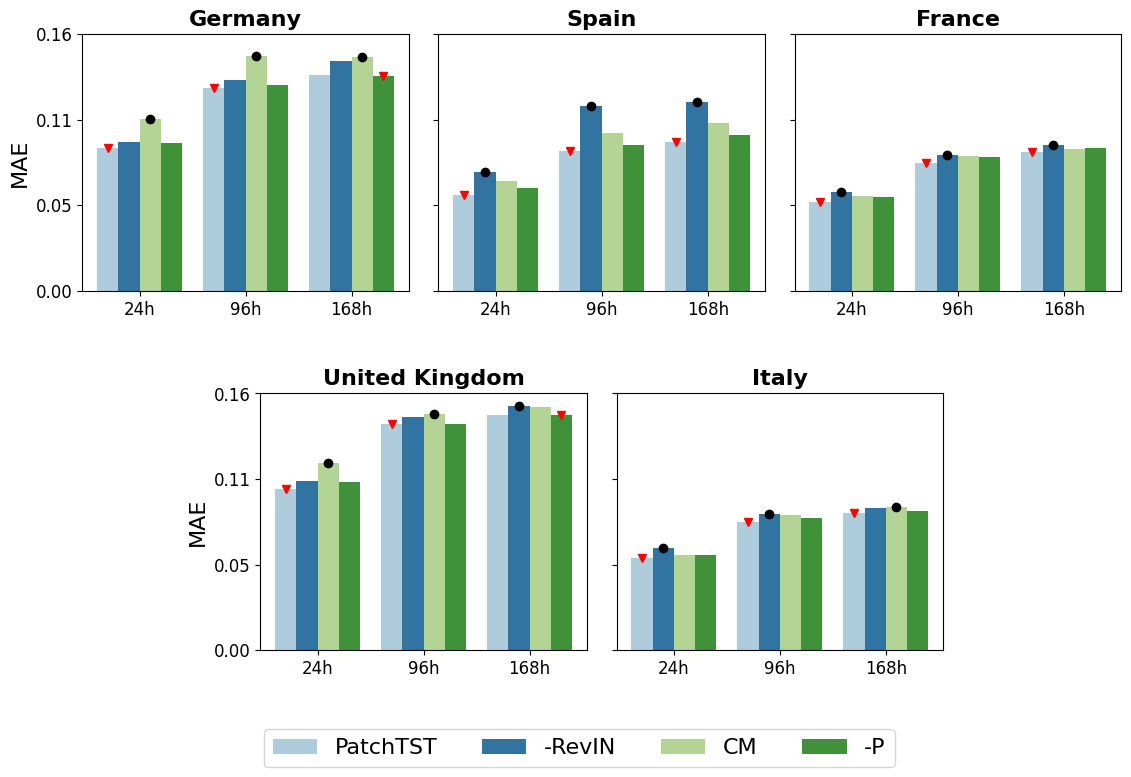

In [147]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

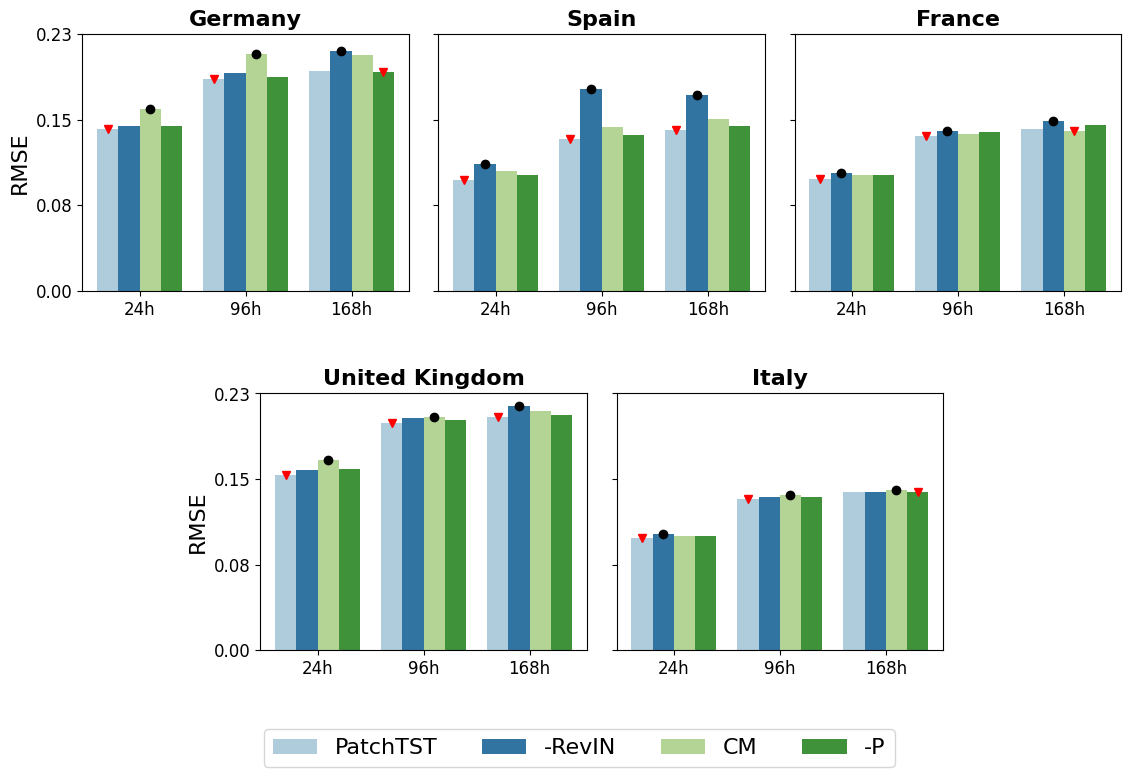

In [148]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

In [26]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

# 5. TimeLLM

In [35]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM/512', ['RMSE', 'MAE'])
                              )
timellm_df_336 = read_results_csv('timellm/timellm_336.csv', 
                              columns_to_extract = ('TimeLLM/336', ['RMSE', 'MAE'])
                              )
timellm_df_168 = read_results_csv('timellm/timellm_168.csv',
                                      columns_to_extract=('TimeLLM/168', ['RMSE', 'MAE'])
                                      )
timellm_dfs = pd.concat([timellm_df_168, timellm_df_336, timellm_df], axis=1)
#all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
timellm_dfs.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in timellm_dfs.index],
    names=level_names
)

# Scale
timellm_dfs_scale = timellm_dfs * scale

# Highlight minimum values in bold
styled_df = style_dataframe(timellm_dfs_scale, decimal_places=2)
styled_df

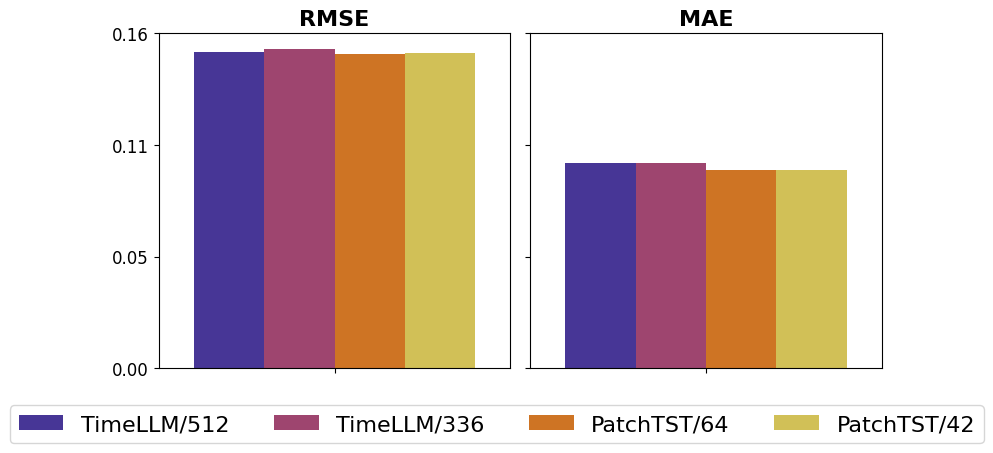

In [43]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [ ]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [35]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [37]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [38]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 6. Decomposition

In [151]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([result_df, decomposition_df_scale], axis=1)

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df